In [1]:
import pysyd

## TL;DR
`pySYD` is adapted from the IDL-based asteroseismic pipeline, `SYD`, which has been a very powerful for automating the detection of solar-like oscillations. The analysis is basically two-fold:

 1. remove crude background fit and estimate numax
 2. remove proper background fit and estimate numax (+ other things)

### Step 1: load default parameters

This step is analogous to running software via command-line, which has a lot of these parameters set to their defaults. Most of them should never need to be touched... unless you have a giant star with low numax.

In [2]:
from pysyd.utils import Parameters

# KIC 1435467
name = '1435467'
args = Parameters()

print(args.__dict__.keys())
#print(args.__dict__)

dict_keys(['constants', 'params'])


### Step 2: add target(s)

This will draw from information (via stars_info.csv) when available and then pull the rest of the needed parameters from the defaults to create a new (sub)dictionary for each target.

In [3]:
args.add_targets(stars=[name])

print(args.params[name])

{'path': '/Users/ashleychontos/pysyd/results/1435467', 'star': '1435467', 'seed': None, 'show': False, 'save': True, 'test': False, 'verbose': False, 'overwrite': False, 'warnings': False, 'stitch': False, 'gap': 20, 'kep_corr': False, 'oversampling_factor': None, 'estimate': True, 'numax': None, 'force': False, 'dnu': None, 'binning': 0.005, 'bin_mode': 'mean', 'lower_ex': None, 'upper_ex': None, 'step': 0.25, 'smooth_width': 20.0, 'n_trials': 3, 'ask': False, 'background': True, 'basis': 'tau_sigma', 'box_filter': 1.0, 'fix_wn': False, 'n_laws': None, 'ind_width': 20.0, 'lower_bg': None, 'upper_bg': None, 'metric': 'bic', 'n_rms': 20, 'globe': True, 'ex_width': 1.0, 'lower_ps': None, 'upper_ps': None, 'sm_par': None, 'n_peaks': 5, 'smooth_ps': 2.5, 'fft': True, 'threshold': 1.0, 'hey': False, 'cmap': 'binary', 'clip_value': 3.0, 'interp_ech': False, 'notching': False, 'lower_ech': None, 'upper_ech': None, 'npb': 10, 'nox': None, 'noy': '0+0', 'ridges': False, 'smooth_ech': None, 'mc_

### Step 3: create pipeline target

Now that we have our two main ingredients we can create a `Target` object, which is where a bulk of the analysis will occur. This will essentially pop that (sub)dictionary from above and then attempt to load in the data.

In [4]:
from pysyd.target import Target

star = Target(name, args)
# Let's change some defaults
star.params['show'] = True
star.params['verbose'] = True
cont = star.load_data()


-----------------------------------------------------------
Target: 1435467
-----------------------------------------------------------
# LIGHT CURVE: 37919 lines of data read
# Time series cadence: 59 seconds
# POWER SPECTRUM: 99518 lines of data read
# PS oversampled by a factor of 6
# PS resolution: 0.512242 muHz


If it has done so successfully, the verbose output (i.e. above) will tell you about the files it loaded in and automatically calculate if the power spectrum is over- or critically-sampled. From this point, the code works in those two steps I mentioned at the beginning.

### Step 4: crude background fit

In [5]:
# First go
star.estimate_parameters()

-----------------------------------------------------------
PS binned to 225 datapoints

Numax estimates
---------------
Estimate 1: 31.44 +/- 2.02
S/N: 42.46
Estimate 2: 76.09 +/- 3.61
S/N: 8.24
Estimate 3: 1448.45 +/- 95.83
S/N: 6.23
Selecting model 1


-> insert first thing that can go wrong

Here we know the numax for Estimate (3) is basically correct since it's fairly high S/N but it's selecting the first model. We can get around this through the `ask` parameter, which literally means to ask you which model to select instead. More generally, this is a helpful parameter to use if you think something is going wrong in this first step because it will output a figure that can help diagnose most issues.


-----------------------------------------------------------
Target: 1435467
-----------------------------------------------------------
# LIGHT CURVE: 37919 lines of data read
# Time series cadence: 59 seconds
# POWER SPECTRUM: 99518 lines of data read
# PS oversampled by a factor of 6
# PS resolution: 0.512242 muHz
-----------------------------------------------------------
PS binned to 225 datapoints

Numax estimates
---------------
Estimate 1: 31.44 +/- 2.02
S/N: 42.46
Estimate 2: 76.09 +/- 3.61
S/N: 8.24
Estimate 3: 1448.45 +/- 95.83
S/N: 6.23


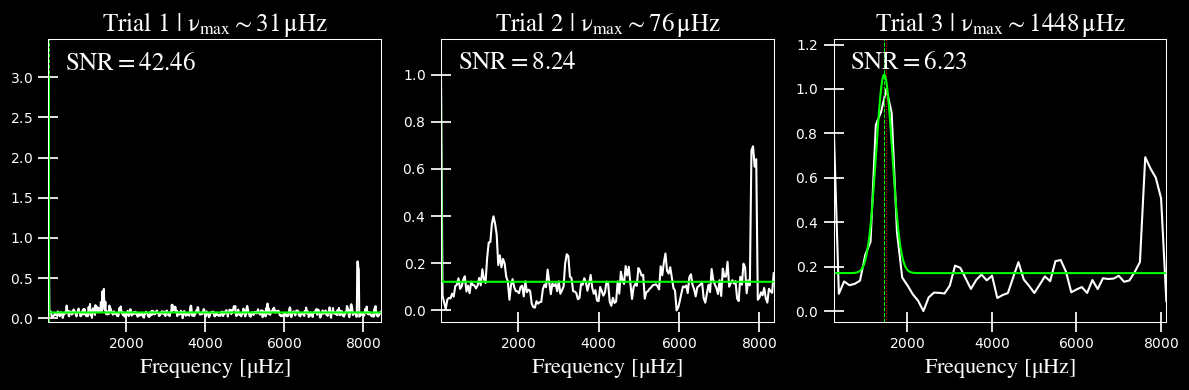


Which estimate would you like to use? 3
Selecting model 3


In [6]:
# Second go
name, args = '1435467', Parameters()
args.add_targets(stars=[name])
star = Target(name, args)
star.params['show'] = True
star.params['verbose'] = True
star.params['ask'] = True
cont = star.load_data()
star.estimate_parameters()

And then we have our final scenario... the real scenario.

Let's say that I know I've used a high-pass filter so the low frequencies cannot be trusted and that there is also a high-frequency artefact that I want the program to ignore. 

In [7]:
# Third go
name, args = '1435467', Parameters()
args.add_targets(stars=[name])
star = Target(name, args)
star.params['show'] = True
star.params['verbose'] = True
star.params['lower_ex'] = 100.0
star.params['upper_ex'] = 6000.0
cont = star.load_data()
star.estimate_parameters()


-----------------------------------------------------------
Target: 1435467
-----------------------------------------------------------
# LIGHT CURVE: 37919 lines of data read
# Time series cadence: 59 seconds
# POWER SPECTRUM: 99518 lines of data read
# PS oversampled by a factor of 6
# PS resolution: 0.512242 muHz
-----------------------------------------------------------
PS binned to 189 datapoints

Numax estimates
---------------
Estimate 1: 1430.02 +/- 72.61
S/N: 2.43
Estimate 2: 1479.46 +/- 60.64
S/N: 4.87
Estimate 3: 1447.42 +/- 93.31
S/N: 13.72
Selecting model 3


So now that we are absolutely sure we have a good estimate for numax, we can let the software do its thing... and derive the stellar background and global asteroseismic parameters.

FWIW the reason this is done in a two-step process is because for solar-like oscillations, we know there is localized power due to the oscillations but there is also various red and white noise components which can affect the reliability of yours results. Therefore for the proper background fit in this next step, the region of oscillations is actually masked out for that very reason.

### Step 5: derive all parameters

In [8]:
star.derive_parameters()

-----------------------------------------------------------
GLOBAL FIT
-----------------------------------------------------------
PS binned to 363 data points

Background model
----------------
Comparing 8 different models:
Model 0: 0 Harvey-like component(s) + white noise fixed
 BIC = 1776.58 | AIC = 4.89
Model 1: 0 Harvey-like component(s) + white noise term
 BIC = 1811.53 | AIC = 4.98
Model 2: 1 Harvey-like component(s) + white noise fixed
 BIC = 943.22 | AIC = 2.58
Model 3: 1 Harvey-like component(s) + white noise term
 BIC = 950.66 | AIC = 2.59
Model 4: 2 Harvey-like component(s) + white noise fixed
 BIC = 902.50 | AIC = 2.44
Model 5: 2 Harvey-like component(s) + white noise term
 BIC = 951.57 | AIC = 2.57
Model 6: 3 Harvey-like component(s) + white noise fixed
 BIC = 899.35 | AIC = 2.41
Model 7: 3 Harvey-like component(s) + white noise term
 BIC = 961.88 | AIC = 2.57
Based on BIC statistic: model 6


-----------------------------------------------------------
Output parameters
-----------------------------------------------------------
numax_smooth: 1309.97 muHz
A_smooth: 1.49 ppm^2/muHz
numax_gauss: 1356.55 muHz
A_gauss: 1.30 ppm^2/muHz
FWHM: 284.17 muHz
dnu: 70.64 muHz
tau_1: 58593353.50 s
sigma_1: 5.51 ppm
tau_2: 136.60 s
sigma_2: 32.65 ppm
tau_3: 151.38 s
sigma_3: 63.44 ppm
-----------------------------------------------------------
- displaying figures -


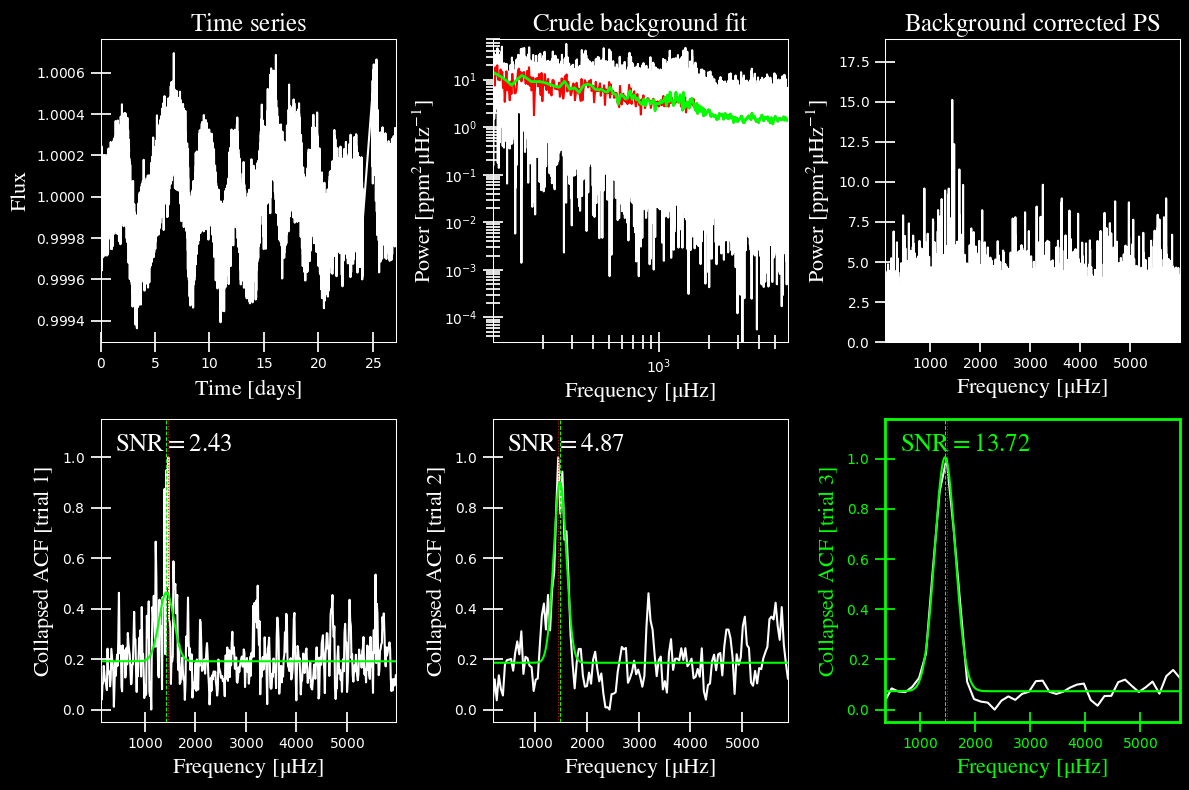

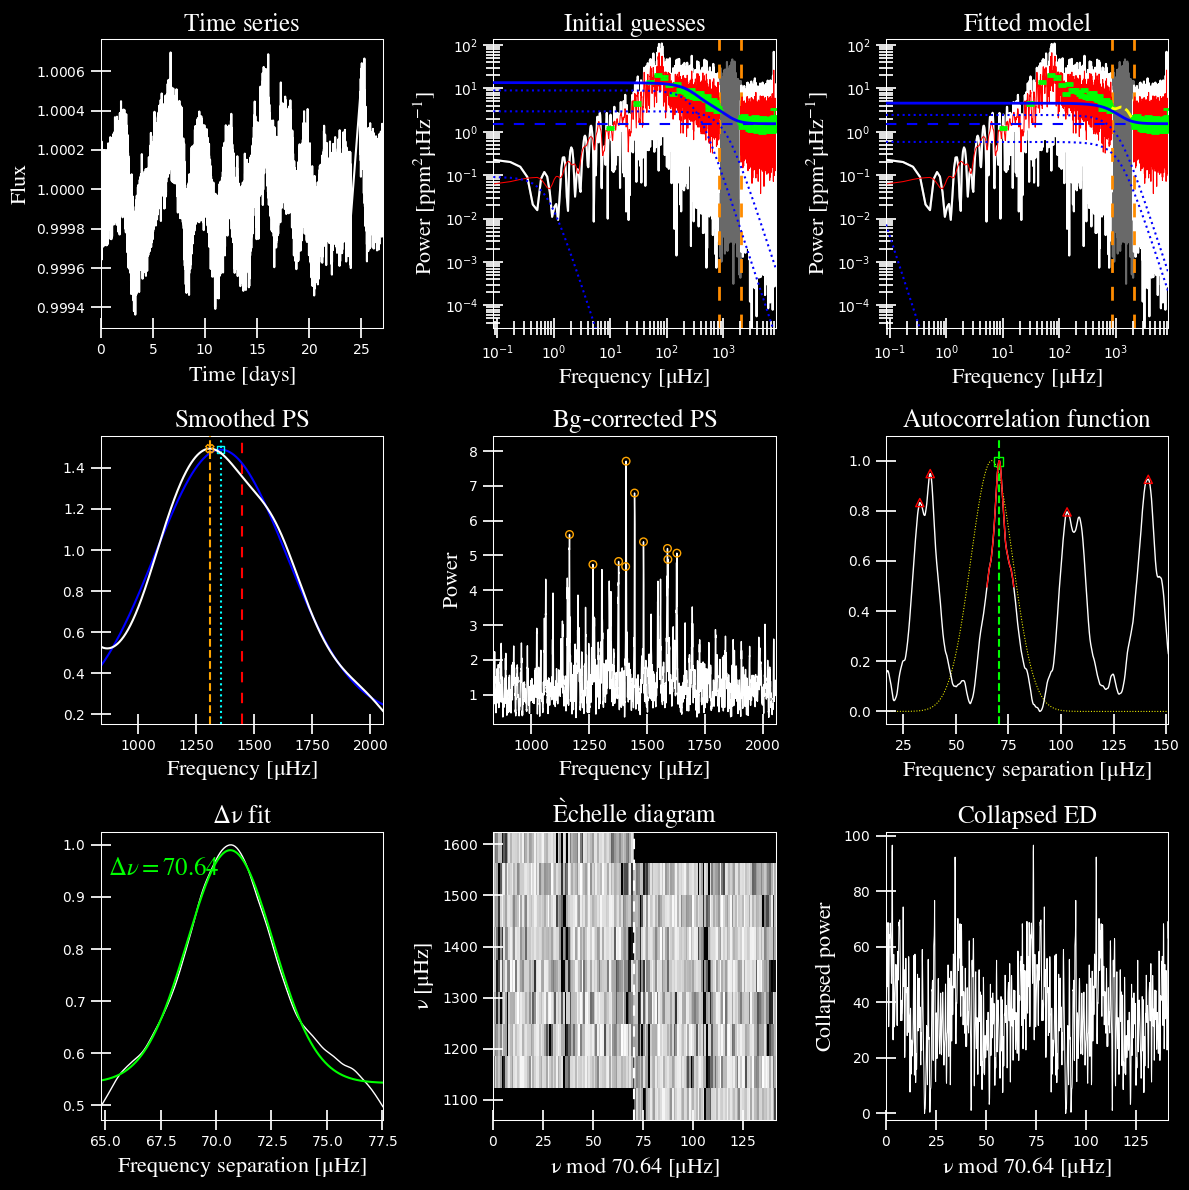

- press [RETURN] to exit -



In [9]:
star.show_results()

### Putting this all together

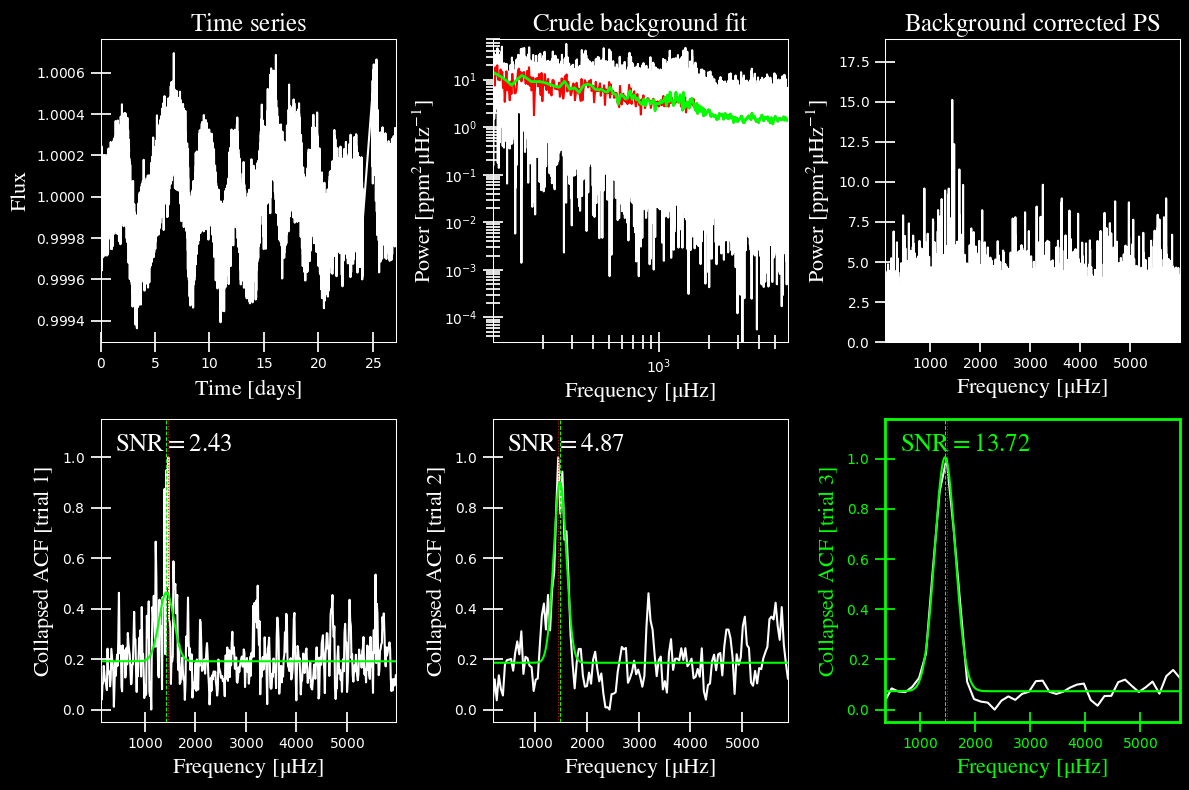

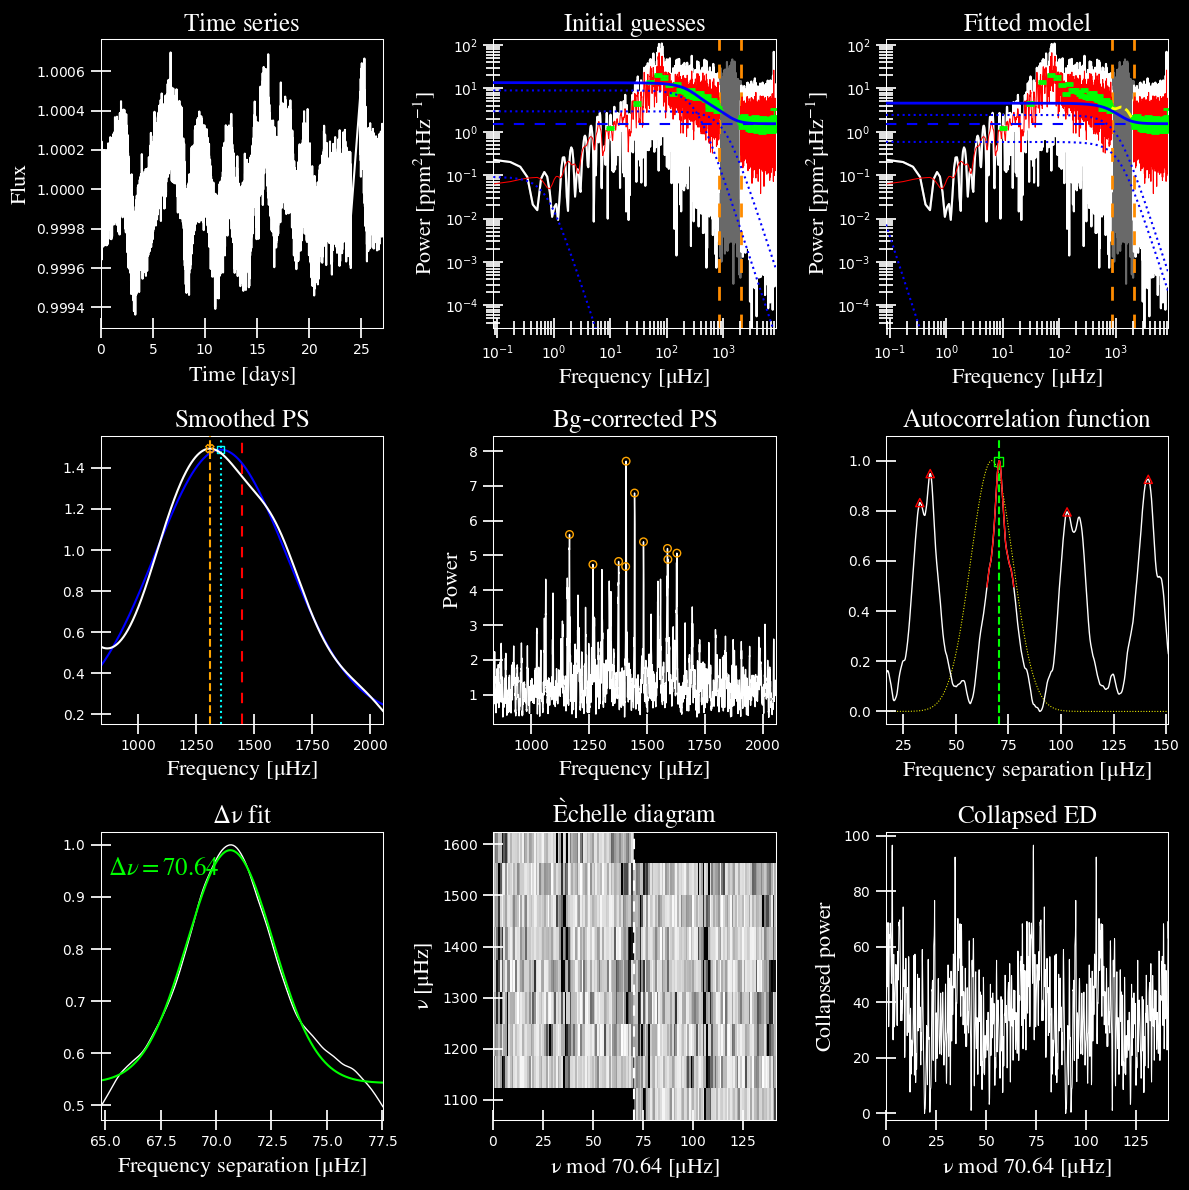

In [10]:
name, args = '1435467', Parameters()
args.add_targets(stars=[name])
star = Target(name, args)
star.params['show'] = True
star.params['lower_ex'] = 100.0
star.params['upper_ex'] = 6000.0
cont = star.load_data()
star.estimate_parameters()
star.derive_parameters()
star.show_results()

## A more evolved star


-----------------------------------------------------------
Target: 11618103
-----------------------------------------------------------
# LIGHT CURVE: 27144 lines of data read
# Time series cadence: 1765 seconds
# POWER SPECTRUM: 73343 lines of data read
# PS oversampled by a factor of 6
# PS resolution: 0.023188 muHz
-----------------------------------------------------------
PS binned to 15 datapoints

Numax estimates
---------------
Estimate 1: 104.30 +/- 2.22
S/N: 14.34
Estimate 2: 104.74 +/- 3.03
S/N: 17.97
Estimate 3: 106.48 +/- 5.61
S/N: 57.22
Selecting model 3
-----------------------------------------------------------
GLOBAL FIT
-----------------------------------------------------------
PS binned to 10 data points

Background model
----------------
Comparing 8 different models:
Model 0: 0 Harvey-like component(s) + white noise fixed
 BIC = 18745571.17 | AIC = 1874557.12
Model 1: 0 Harvey-like component(s) + white noise term
 BIC = 18695586.96 | AIC = 1869558.67
Model 2: 1 H

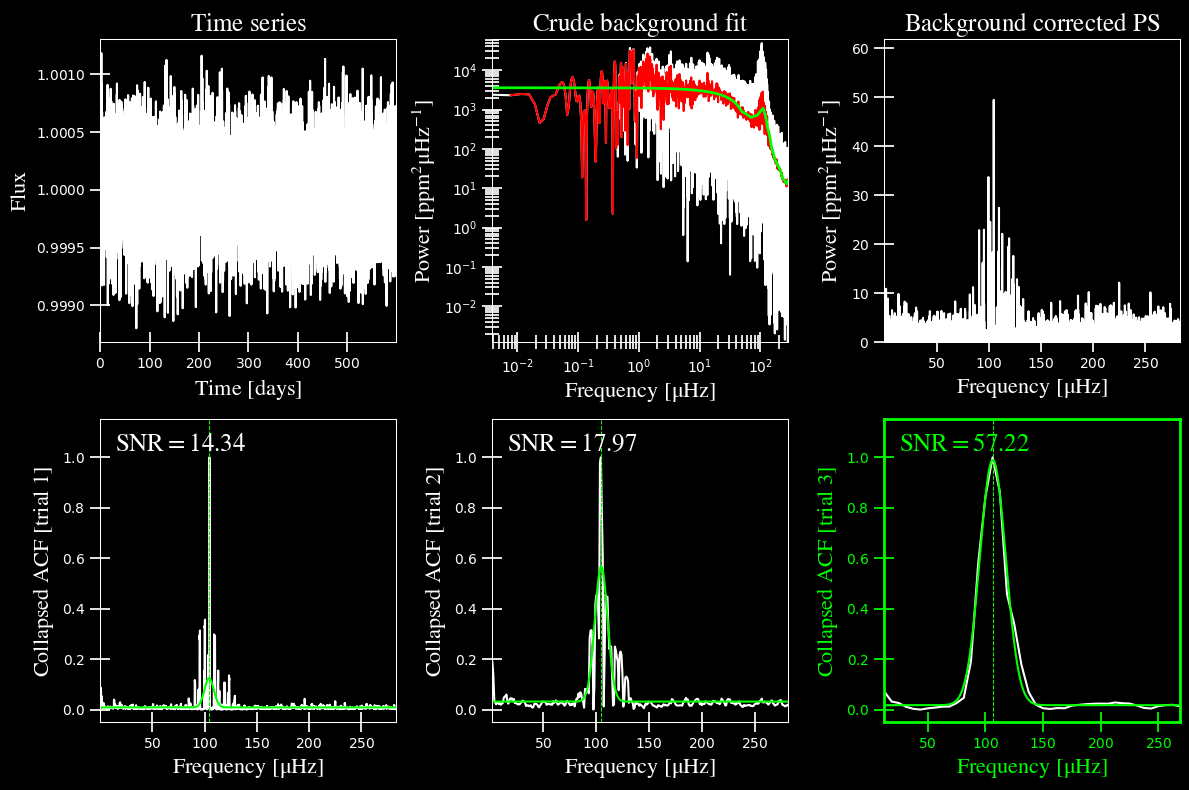

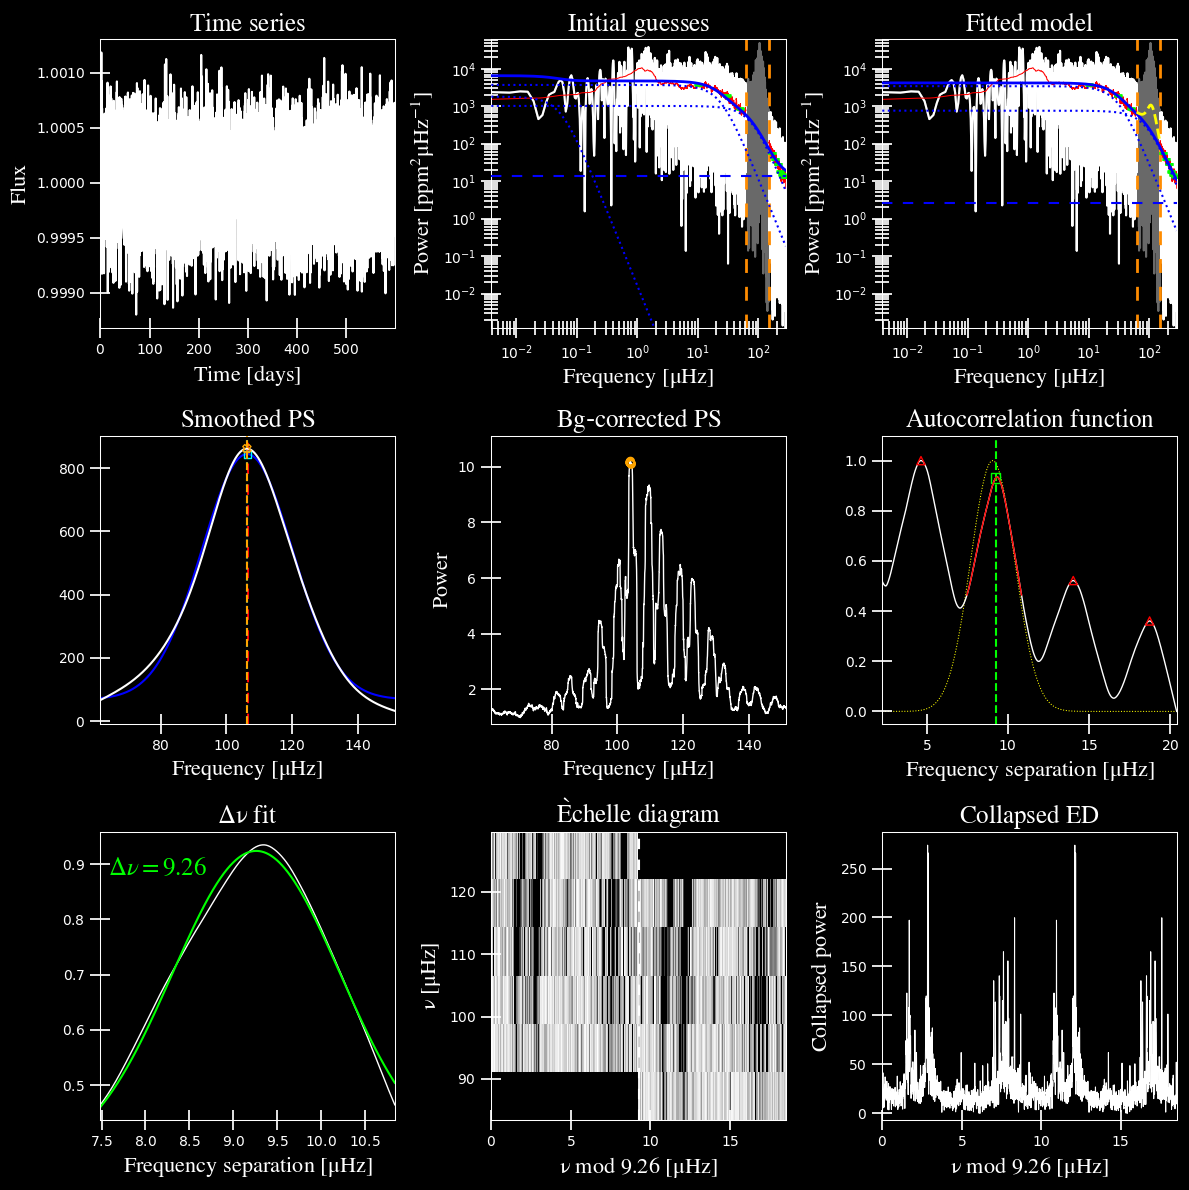

- press [RETURN] to exit -



In [11]:
name, args = '11618103', Parameters()
args.add_targets(stars=[name])
star = Target(name, args)
star.params['show'] = True
star.params['verbose'] = True
cont = star.load_data()
star.estimate_parameters()
star.derive_parameters()
star.show_results()

## Even more evolved?

Things that are affected at lower frequencies:
1. crude background fit 
   - smoothing (`--sw`, `--smoothwidth`) of power spectrum (green/red lines, panel 2 of 6 in first figure)
   - adjust (parameter) option for more evolved stars (or some similar keyword that allows you to provide 'MS', 'SG', 'RG' or something similar)
   
2. main parameter derivation
   - box filter (`--bf`, `--box`) only affects plotting, does not affect results
   - independent width (`--iw`, `--indwidth`) acts the same as the smoothing width does in the first module and is also in muHz
   - smoothed power spectrum (`--sp`, `--smoothps`) is a box filter that smooths out the power spectrum before computing the ACF and *does* affect your analysis (middle, middle panel 5 of 9 panel figure)


-----------------------------------------------------------
Target: 11618103
-----------------------------------------------------------
# LIGHT CURVE: 27144 lines of data read
# Time series cadence: 1765 seconds
# POWER SPECTRUM: 73343 lines of data read
# PS oversampled by a factor of 6
# PS resolution: 0.023188 muHz
-----------------------------------------------------------
PS binned to 189 datapoints

Numax estimates
---------------
Estimate 1: 104.53 +/- 5.68
S/N: 3.57
Estimate 2: 107.46 +/- 6.69
S/N: 11.06
Estimate 3: 108.43 +/- 7.22
S/N: 26.68
Selecting model 3
-----------------------------------------------------------
GLOBAL FIT
-----------------------------------------------------------
PS binned to 192 data points

Background model
----------------
Comparing 6 different models:
Model 0: 0 Harvey-like component(s) + white noise fixed
 BIC = 388683841.38 | AIC = 2024395.01
Model 1: 0 Harvey-like component(s) + white noise term
 BIC = 387804359.20 | AIC = 2019814.35
Model 2: 

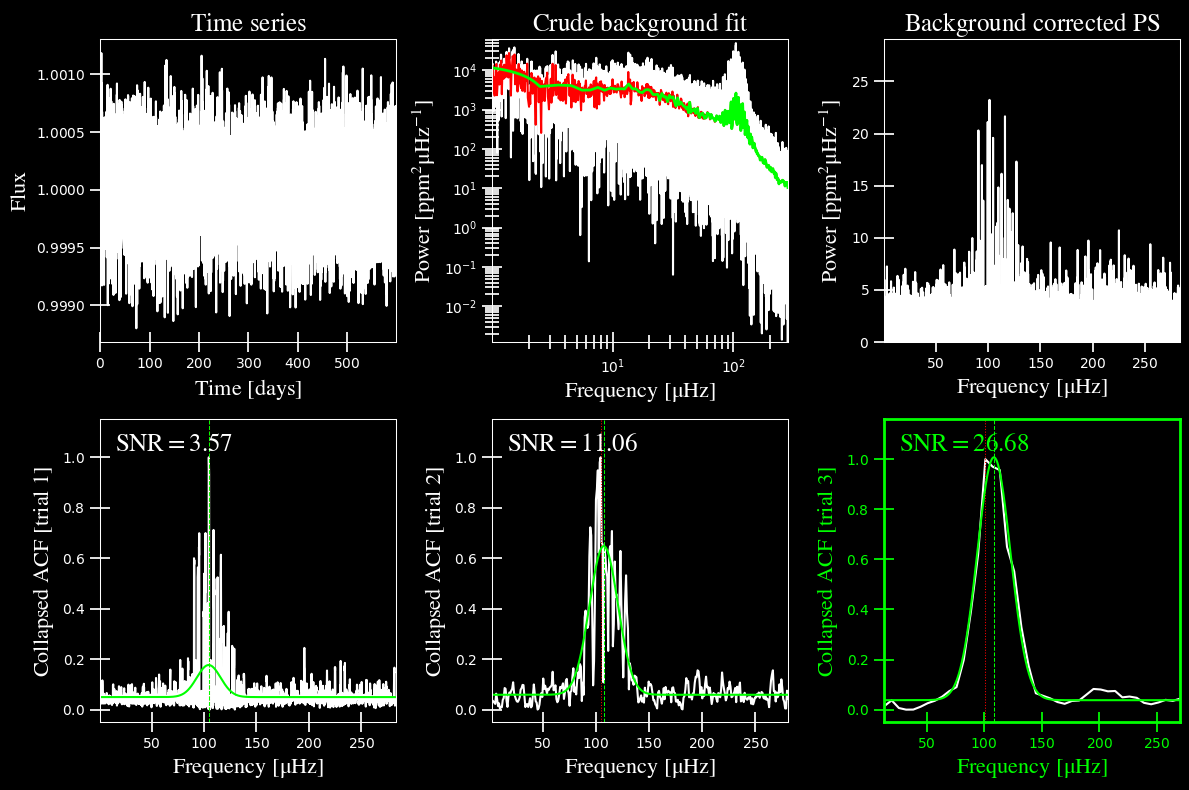

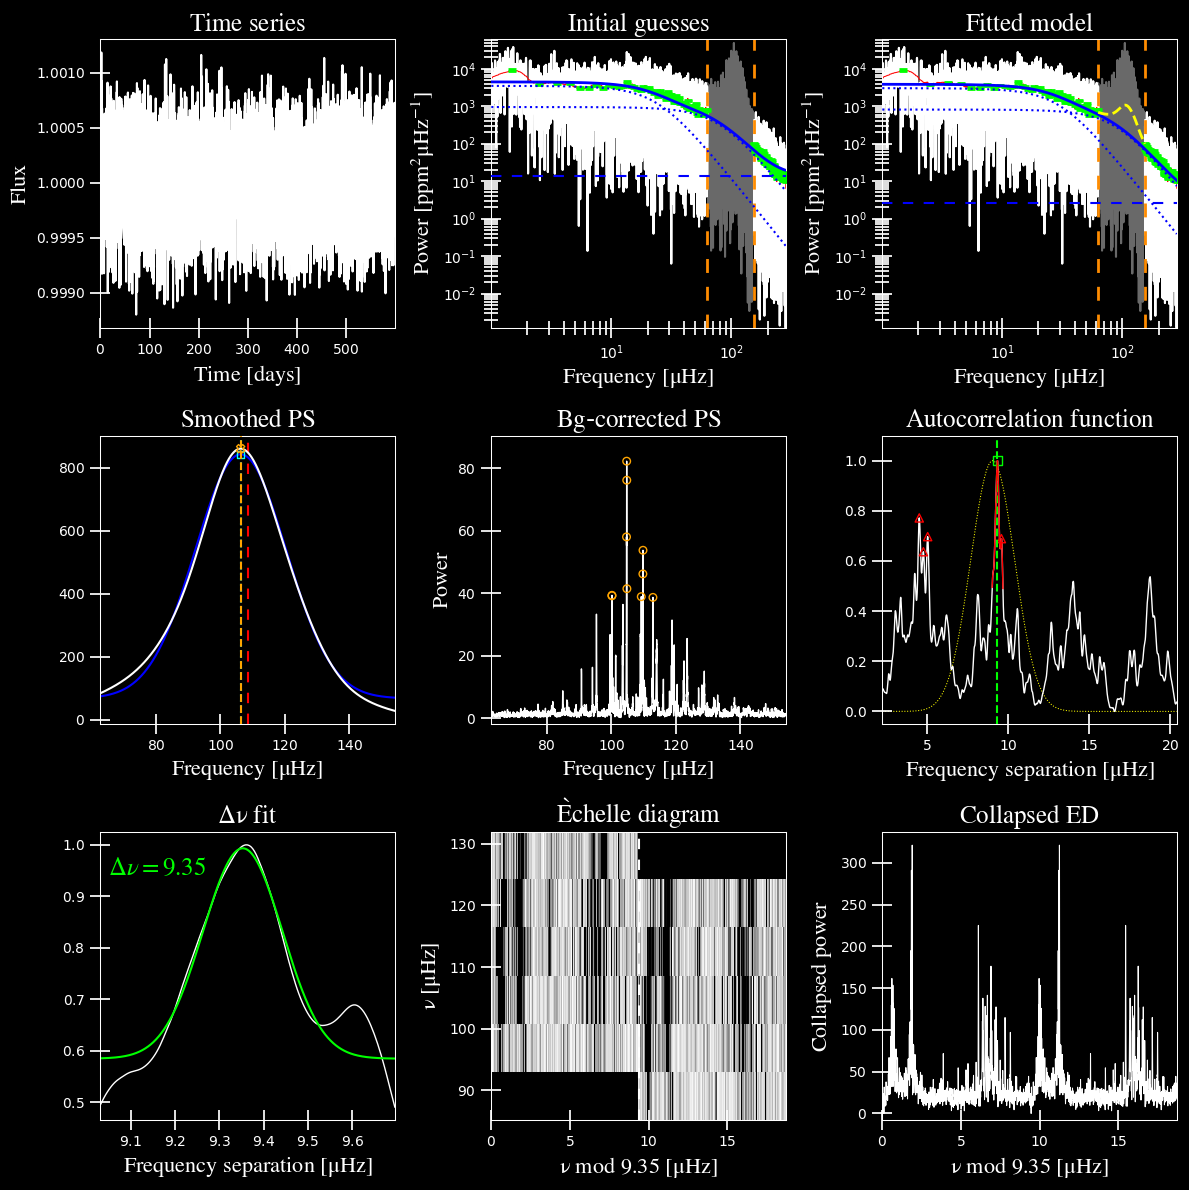

- press [RETURN] to exit -



In [13]:
name, args = '11618103', Parameters()
args.add_targets(stars=[name])
star = Target(name, args)
star.params['show'] = True
star.params['verbose'] = True
# first module
star.params['smooth_width'] = 1.0
star.params['lower_ex'] = 1.0
# second module
star.params['ind_width'] = 1.0
star.params['smooth_ps'] = 0.1
star.params['lower_bg'] = 1.0
cont = star.load_data()
star.estimate_parameters()
star.derive_parameters()
star.show_results()

Ideas:
1. separate CL options into different topics (i.e. data processing, plot-related) I'm pretty sure this is done for getting pySYD defaults anyway so I'm not sure why it isn't organized that way there